# Module 1.6: Looking at the Data

> **Goal: Learn how to translate the 5Q Framework into practical first-contact checks on real forecasting data.**

In Module 1.3, we introduced the **5Q Framework** — the five questions that shape every forecasting problem:

Your first pass through the dataset should confirm **whether the data can support the 5Q**.

- **Q1 — Decision (Target):**  
  Is the target clear, numeric, and clean?

- **Q2 — Metric:**  
  Are there issues (missingness, outliers, duplicates) that would bias evaluation?

- **Q3 — Horizon & Level (Structure):**  
  Do we have enough history, the right frequency, and consistent granularity?

- **Q4 — Data & Drivers:**  
  What early behavioral signals (volatility, zeros, trends) shape the model?

- **Q5 — Ownership:**  
  Who owns inputs, outputs, and data quality?



This is an **initial assessment**, not final conclusions. As we refine and explore the data throughout Module 1, these answers will become clearer.

In this notebook, we will:

1. **Load** the M5 dataset
2. **Run systematic diagnostics** using TSForge
3. **Visualize** key patterns and anomalies
4. **Interpret findings** through the 5Q lens
5. **Document actions and flags** to carry into the next module

---

## 1. Setup

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tsforge.eda import *
from tsforge.feature_engineering import *
import tsforge as tsf

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"NumPy {np.__version__}")
print(f"\n✓ Setup complete")

/Users/lindsaytruong/anaconda3/envs/ts_forge/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/lindsaytruong/anaconda3/envs/ts_forge/lib/python3.10/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Python 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:46:00) [Clang 18.1.8 ]
Pandas 2.3.2
NumPy 2.0.2

✓ Setup complete


In [3]:
# Set up paths
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Output directory: {OUTPUT_DIR.absolute()}")

Data directory: /Users/lindsaytruong/Downloads/data
Output directory: /Users/lindsaytruong/Downloads/output


## 2. Data: The M5 Dataset

The **M5 dataset** contains Walmart's daily sales history across thousands of item-store combinations.

**Three main files:**
1. **Sales (`y_df`)** – daily unit sales per item-store
2. **Calendar (`calendar_df`)** – holidays, events, SNAP eligibility
3. **Prices (`prices_df`)** – weekly item-store pricing

Together, these files reflect real retail forecasting: products, stores, events, promotions, pricing. We'll use this dataset throughout the course to build a **production-ready forecasting pipeline** that mirrors real retailer workflows.

---

### What This Module Covers

**We're working with raw sales data only (`y_df`):**
- `unique_id` — item-store identifier
- `ds` — date
- `y` — units sold

**Our goal:** Perform essential first-contact triage on the demand signal to assess if it can support the 5Q Framework.

This systematic check is **critical** for every forecasting project. It reveals what problems exist, what constraints we face, and whether this target is viable before we invest time in feature engineering or modeling.

**What we're checking:**
- **History length** → Q3: Enough data for our forecast horizon?
- **Missing data & duplicates** → Q2: Will evaluation metrics be reliable?
- **Intermittency (zeros)** → Q1: Can standard methods handle this target?
- **Volatility** → Q4: Are patterns stable or event-driven?
- **Outliers** → Q2/Q4: Data quality issues or real demand spikes?

---

### What Comes in Later Modules

The broader M5 context—categories, stores, calendar events, pricing—comes when we need it to **explain** the patterns we identify here.

**Module 1.7** → Understand M5 structure and product/store hierarchy  
**Module 1.8** → Merge calendar + pricing data (safely, avoiding leakage)  
**Module 1.9** → Clean outliers, fill gaps, validate modeling readiness

These modules will help us understand the volatility and spikes we discover in this first-contact check.

---

### 2.1 Load Data

We're loading the M5 dataset directly from the `datasetsforecast` package. This dataset is widely used in forecasting research and competitions, and it comes **clean, standardized, and already validated**.

`tsf.load_m5()` uses a **local-first** approach:

- If the M5 files already exist in `DATA_DIR`, it **loads them directly**.
- If not, it **downloads them from the `datasetsforecast` package`** and saves them locally.
- With `verbose=True`, it prints what was found or downloaded.


In [4]:
# Load clean M5 dataset from datasetsforecast package
print("Loading M5 from datasetsforecast package...")
Y_df = tsf.load_m5(DATA_DIR)
print(f"\n✓ Loaded clean M5 from datasetsforecast")

Loading M5 from datasetsforecast package...
✓ M5 cache detected. Loading from local files...
✓ Loaded in 1.2s
  Shape: 47,649,940 rows × 3 columns
  Memory: 638.4 MB
  Columns: unique_id, ds, y
  Returning: Y_df only (time series data)

✓ Loaded clean M5 from datasetsforecast


### 2.2 Messify the Data (Simulating Real-World Conditions)

Since the M5 dataset from `datasetsforecast` is a "clean" dataset, it doesn't reflect the messy reality of the raw M5 data used in the Kaggle competition. To practice realistic diagnostics, we'll intentionally **messify** it.

We'll use `messify_m5_data()` to introduce common data problems you'd see in practice. This helps you build the skills to detect, diagnose, and fix issues that don't appear in the clean benchmark version.

This introduces the most common issues you'll encounter in real pipelines:

- **Zeros → NA (15%)** — mimics missing reporting or suppressed sales
- **Duplicate rows added** — simulates faulty merges or repeated ingestion jobs
- **Corrupted data types** — dates as strings, numbers as text
- **Gaps in the date sequence** — represents real-world missing days
- **String artifacts ("NA", "NULL")** — common in CSV exports or manual edits
- **Inconsistent ID formats** — underscores vs hyphens, casing differences

These changes give us a more realistic dataset to test our diagnostics and cleaning workflow against.

**Your job:** Detect all of these in your inventory and document them for data prep.

In [4]:
df = tsf.messify_m5_data(
    Y_df,
    random_state=42,
    zero_to_na_pct=0.15,
    add_duplicates=True,
    n_duplicates=150,
    corrupt_dtypes=True,
    remove_zero_dates=True,
    zero_date_removal_pct=0.02,
    cache_dir=DATA_DIR,  # Cache in data folder
    verbose=True
)


print(f"\n✓ Working with messified subset")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\n✓ Working with {len(df):,} rows across {df['unique_id'].nunique()} series")

LOADING CACHED MESSIFIED DATA

📁 Cache file: m5_messy_n30490_rs42_zna15_dup150_dtype1_rmv2.parquet
   Using cached version (skip messification)

💡 To regenerate: set force_refresh=True

✓ Loaded 47,083,514 rows × 3 columns

✓ Working with messified subset
  Shape: 47,083,514 rows × 3 columns

✓ Working with 47,083,514 rows across 30490 series


---

## 3. First Contact: Quick Data Inventory

Now that we’ve deliberately messified the clean M5 dataset, we can treat it the way we would treat real production data.  

This module is about building the **first-contact checks** you should run the moment you receive a new dataset.

Why? Because before modeling, feature engineering, or even choosing metrics, you need to answer a single question:

> **"Do I have the right data to support the 5Q?"**

- Is the **target** valid and trustworthy? (Q1)
- Is the data reliable enough to support meaningful **metrics**? (Q2)
- Do we have enough **history** and the right **granularity**? (Q3)
- What does the raw behavior suggest about **drivers** we may need? (Q4)

This section guides you through those foundational checks — the ones that tell you whether the dataset can support the forecasting decision.

### 3.1 Data Structure Check

We'll start with shape, memory, basic schema, and a peek at the first few rows.

**What we're checking:**
- Shape and memory (is it manageable?)
- Column names (standard forecasting format?)
- Data types (correct types or need conversion?)
- First rows (any obvious formatting issues?)
- Duplicate records — does each (unique_id, ds) pair appear only once?



In [5]:
# Quick eyeball: shape and memory
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nColumns: {list(df.columns)}")

Shape: 47,083,514 rows × 3 columns
Memory: 5796.8 MB

Columns: ['unique_id', 'ds', 'y']


In [6]:
# First 10 rows
print("\nFirst 10 rows:")
display(df.head(10))


First 10 rows:


,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0
5,FOODS_1_001_CA_1,2011-02-03,2.0
6,FOODS_1_001_CA_1,2011-02-04,nan
7,FOODS_1_001_CA_1,2011-02-05,2.0
8,FOODS_1_001_CA_1,2011-02-06,0.0
9,FOODS_1_001_CA_1,2011-02-07,0.0


In [7]:
# Data types
print("\nData types:")
print(df.dtypes)


Data types:
unique_id    category
ds             object
y              object
dtype: object


In [8]:
# Check for duplicates based on 'unique_id' and 'date'
duplicates = df.duplicated(subset=['unique_id', 'ds'], keep=False)
duplicate_rows = df[duplicates]
print(f"Found {len(duplicate_rows)} duplicate rows:")
print(duplicate_rows.head(20))

Found 290 duplicate rows:
                unique_id          ds     y
70075    FOODS_1_004_WI_1  2014-09-04  14.0
152908   FOODS_1_010_TX_2  2011-12-13   1.0
281717   FOODS_1_017_WI_3  2013-08-03   1.0
1081642  FOODS_1_065_TX_1  2011-03-19   0.0
1188711  FOODS_1_072_CA_2  2014-09-07   0.0
1829117  FOODS_1_110_CA_3  2013-09-10   5.0
1876728  FOODS_1_113_TX_2  2014-02-10   6.0
2795507  FOODS_1_172_CA_2  2011-10-10   0.0
2798019  FOODS_1_172_CA_3  2013-04-28   0.0
2871990  FOODS_1_176_CA_3  2013-08-26   0.0
3777944  FOODS_2_013_CA_3  2014-09-15   6.0
4065765  FOODS_2_032_WI_2  2016-03-01   4.0
4367848  FOODS_2_054_CA_3  2011-08-13  17.0
4837317  FOODS_2_084_WI_1  2015-03-13   2.0
6475360  FOODS_2_204_WI_3  2014-02-06   1.0
6596772  FOODS_2_213_TX_2  2013-12-24   0.0
6696138  FOODS_2_220_WI_3  2015-01-13   0.0
6806926  FOODS_2_228_WI_1  2014-04-04   0.0
7029669  FOODS_2_242_TX_3  2011-03-24   0.0
7047795  FOODS_2_243_TX_3  2015-01-17   1.0


**What we observed:**
- 3-column schema (`unique_id`, `ds`, `y`)
- 47,083,514 rows
- 5796.8 MB footprint
- `unique_id` has correct datatype
- `ds` stored as **string** (should be datetime)
- `y` stored as **string** (should be numeric)
- 290 duplicate rows detected

**What it means:**
- The dataset follows the **typical forecasting structure**
- This dataset is large (~47M rows), and current memory usage may exceed **5–6 GB** in a typical local Jupyter environment
- Because both dates and targets are stored as strings, they need to be fixed— these types will **break indexing, grouping, and all time-series operations** if left as-is.
- The initial rows show many zeros and low values, indicating **intermittent retail-style demand** that we’ll need to account for later

**Actions required:**
1. Convert `ds` to datetime
2. Convert `y` to numeric
3. Remove duplicates
4. Flag intermittent demand pattern for later modeling
5. As we move into more computationally heavy modules, you may need to **subset the data** or work with **lighter samples** to avoid slowdowns or kernel restarts.

### 3.3 Apply Data Type Conversions

Now let's fix the data types and drop duplicates so we can look at summary statistics.

In [9]:
# Convert to proper data types
df['ds'] = pd.to_datetime(df['ds'], format='mixed', errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')

print("\nData types after conversion:")
print(df[['ds', 'y', 'unique_id']].dtypes)


Data types after conversion:
ds           datetime64[ns]
y                   float64
unique_id          category
dtype: object


In [10]:
# drop duplicates
df = df.drop_duplicates(subset=['unique_id', 'ds'])

### 3.2 Basic Descriptive Statistics

Now with proper data types, we can see the true statistical distribution. let's see what a quick `describe()` reveals about the raw data.

In [11]:

df.describe()

,ds,y
count,47083369,4.291888e+07
mean,2014-02-16 02:55:13.162386432,1.588026e+00
min,2011-01-29 00:00:00,0.000000e+00
25%,2012-12-14 00:00:00,0.000000e+00
50%,2014-04-11 00:00:00,0.000000e+00
75%,2015-05-25 00:00:00,2.000000e+00
max,2016-06-19 00:00:00,7.630000e+02
std,NaN,4.498012e+00


**What we observed:**

**History Length:**
* Data spans **Jan 2011 → Jun 2016** (5.5 years).
* Median timestamp sits around **April 2014**, centered within the range.
* This suggests:

  * A long enough window to capture **multiple weekly, monthly, and yearly seasonal cycles**.
  * A **balanced timeline** with no early- or late-history skew, so diagnostics reflect the full period.

**Demand Shape:**
* Average demand ≈ **1.59 units**, with the 25th/50th percentiles at **0** and the 75th at **2**.
* This means:

  * Most series are **extremely low-volume** and **highly intermittent**.
  * Zero-heavy distributions make percentage errors unstable, so metric choice is critical.
* Maximum demand = **763 units**, far above the mean.
* This indicates:

  * A **heavily right-skewed** distribution with rare but large spikes.
  * Two regimes: many **ultra-low–volume items** + a small set of **high-volume drivers**.
  * We'll need **segmented evaluation** so high-volume items don’t dominate.

**Volatility:**
* Standard deviation ≈ **4.50**, nearly 3× the mean (1.59).
* This signals:

  * **High relative variability** — noise dominates the underlying pattern.
  * Forecast metrics may behave unpredictably in a zero-heavy, high-variance setting.
  * Expect irregular, spike-driven series; consider **robust, scale-independent metrics**.

**Actions required:**
1. Identify and flag **ultra-sparse** series (e.g., >50% zeros).  
2. Use **scale-invariant** metrics (MAE, RMSE, RMSSE; avoid MAPE).  
3. Investigate **extreme spikes** to distinguish true events vs. data errors.  
4. Segment evaluation by **volume tier** to prevent dominance by large items.

---

## 4. Quick Diagnostic Summary

The first-contact checks gave us a taste of what to look for—history coverage, demand shape, volatility, missingness, and early 5Q risks.
But instead of running these checks one by one, we can instead use a single diagnostic function that computes all of them at once.

The `summary_diagnostics` function in TSForge automates the quick checks and extends them, giving us a panel-wide snapshot and structured fields we can sort, filter, group, and investigate. It turns our earlier observations into a complete, flexible diagnostic framework.


In [12]:
# Run comprehensive panel summary
summary = tsf.eda.summary_diagnostics(
    df,
    id_col='unique_id',
    date_col='ds',
    value_col='y'
)

# Display the summary
summary.head()

,unique_id,start_date,end_date,n_obs,freq,n_expected,is_regular,pct_missing,mean_value,sd_value,cv_value,skewness,pct_zeros,pct_outliers,trend_strength
0,FOODS_1_001_CA_1,2011-01-29,2016-06-19,1782,1D,1969,False,9.497207,0.881033,1.309229,1.486017,2.972857,51.515152,2.020202,0.005032
1,FOODS_1_001_CA_2,2011-01-29,2016-06-19,1809,1D,1969,False,8.125952,1.264234,1.820741,1.440192,2.850004,43.781095,2.045329,0.011234
2,FOODS_1_001_CA_3,2011-01-29,2016-06-19,1780,1D,1969,False,9.598781,1.329775,2.414988,1.816087,3.993476,50.000000,2.191011,0.006651
3,FOODS_1_001_CA_4,2011-01-30,2016-06-19,1718,1D,1968,False,12.703252,0.414435,0.771856,1.862427,2.556515,70.314319,2.502910,0.008698
4,FOODS_1_001_TX_1,2011-01-30,2016-06-19,1757,1D,1968,False,10.721545,0.659078,1.371859,2.081482,5.902958,62.834377,2.048947,0.002141


### 4.1 Understanding the Diagnostics Output

> **Note:** Viewing the raw diagnostics table (as shown above) is not very informative on its own. At this level of granularity — and without sorting or filtering — it's just a dense list of series with no clear story. The value of `summary_diagnostics` comes from **how you use it**, not from scanning the table row by row.

Instead of inspecting each series manually, use the diagnostics output to:

- **Sort** — surface the shortest histories, highest missingness, most volatile or intermittent series
- **Filter** — create "risk buckets" (short, sparse, irregular, outlier-heavy)
- **Aggregate** — roll up diagnostics by category, region, channel, department, etc.
- **Flag** — identify series that need special cleaning or modeling treatment

This turns the diagnostics table from a raw dump into a **targeted, actionable EDA workflow**.

**How to Read the Diagnostics Summary:**

| Column | What It Measures | Why It Matters |
|--------|------------------|----------------|
| `n_obs` | Number of actual observations in the series | • Short series lack seasonal signal<br>• Limits cross-validation<br>• May require simpler models |
| `is_regular` | Whether every expected timestamp is present | • Irregular series indicate missing dates<br>• Gaps must be filled or handled before modeling |
| `pct_missing` | Percent of missing values relative to expected periods | • High missingness weakens trend/seasonality learning<br>• Reduces reliability of the series |
| `mean_value` | Average demand level | • Sets the baseline scale of demand<br>• Useful for segmenting low- vs high-volume items |
| `cv_value` | Coefficient of variation (std ÷ mean) | • High CV = noisy, unstable demand<br>• May require robust metrics/models<br>• CV inflates for trending items, short series, or low means |
| `pct_zeros` | Percent of periods with zero demand | • High → intermittent demand<br>• Requires Croston/TSB, middle-out, or ML approaches |
| `pct_outliers` | Percent of values beyond ±3 standard deviations | • Highlights spikes or data errors<br>• Useful for identifying promo-driven or shock-driven behavior |
| `trend_strength` | How much variation is explained by a simple trend line | • High → use trend-capable models<br>• Low/negative → avoid forcing trend (noise > signal) |

In [13]:
# Shortest histories 
summary.sort_values("n_obs").head(5)

# Most missing data 
summary.sort_values("pct_missing", ascending=False).head(5)

# Most intermittent 
summary.sort_values("pct_zeros", ascending=False).head(5)

# Most volatile 
summary.sort_values("cv_value", ascending=False).head(5)

# Most outliers
summary.sort_values("pct_outliers", ascending=False).head(5)

# Strongest trends 
summary.sort_values("trend_strength", ascending=False).head(5)

,unique_id,start_date,end_date,n_obs,freq,n_expected,is_regular,pct_missing,mean_value,sd_value,cv_value,skewness,pct_zeros,pct_outliers,trend_strength
10014,FOODS_3_389_TX_1,2011-03-02,2016-06-19,1751,1D,1937,False,9.602478,6.766990,7.771557,1.148451,0.829899,48.143918,0.456882,0.586578
948,FOODS_1_096_WI_2,2011-01-29,2016-06-19,1901,1D,1969,False,3.453530,17.145187,18.458658,1.076609,1.266786,15.412941,0.736454,0.576880
6760,FOODS_3_064_CA_1,2011-06-03,2016-06-19,1780,1D,1844,False,3.470716,15.779775,12.823480,0.812653,0.686645,16.629213,0.674157,0.533424
946,FOODS_1_096_TX_3,2011-01-29,2016-06-19,1861,1D,1969,False,5.485018,11.602364,13.035389,1.123511,1.138116,31.380978,0.913487,0.493780
12662,FOODS_3_654_CA_3,2012-02-02,2016-06-19,1531,1D,1600,False,4.312500,4.047681,3.838702,0.948371,1.154311,16.198563,0.849118,0.492311


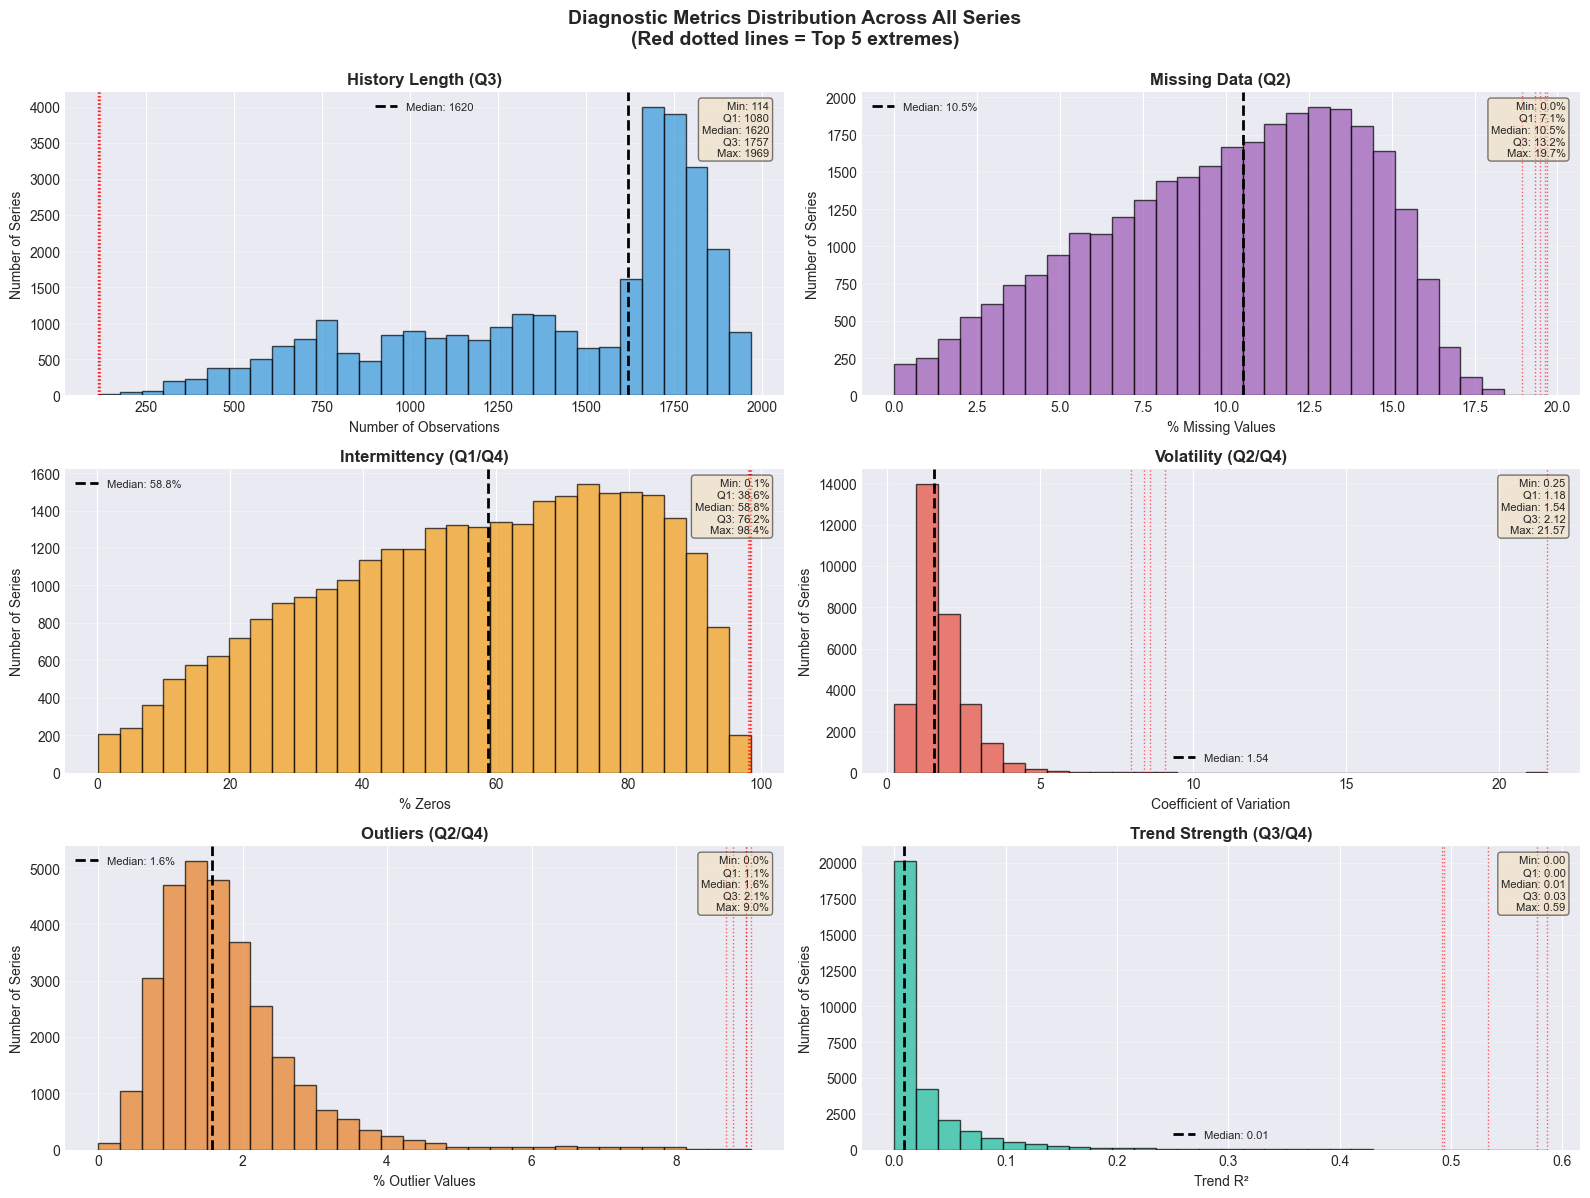


DIAGNOSTIC METRICS SUMMARY
        Metric    5Q  Min    Q1 Median    Q3   Max
History Length    Q3  114  1080   1620  1757  1969
  Missing Data    Q2 0.0%  7.1%  10.5% 13.2% 19.7%
 Intermittency Q1/Q4 0.1% 38.6%  58.8% 76.2% 98.4%
    Volatility Q2/Q4 0.25  1.18   1.54  2.12 21.57
      Outliers Q2/Q4 0.0%  1.1%   1.6%  2.1%  9.0%
Trend Strength Q3/Q4 0.00  0.00   0.01  0.03  0.59


In [14]:
tsf.plots.plot_diagnostics_grid(summary)

### 4.3 Diagnostic Summary: Reading the Grid

We just generated a 6-panel diagnostic grid showing the distribution of key metrics across all series. Here's what each panel reveals.

---

#### **History Length**
- **Distribution**: Bimodal with median 1,620 obs (~4.4 years); range 114-1,969 obs
- **Insight**: Two populations exist - mature items (1,600+ obs) vs. newer items (200-800 obs)
- **Implication**: 75% have sufficient history for annual seasonality; <365 obs series can't capture yearly patterns
- **Action**: Flag short-history series (<365 obs) for category-level aggregation


#### **Missing Data**
- **Distribution**: 7-13% missingness (Q1-Q3); median 10.5%
- **Insight**: Consistent across panel (narrow IQR) suggests systematic issue, not item-specific
- **Implication**: Biases metrics and reduces training data; likely from stock-outs or reporting delays
- **Action**: <5% → forward fill | 5-15% → interpolate | >15% → investigate


#### **Intermittency**
- **Distribution**: Median 58.8% zeros; Q1-Q3 range 38.6%-76.2%
- **Insight**: Highly intermittent demand - more than half of observations are zeros
- **Implication**: Standard ARIMA/ETS will fail; need Croston, TSB, or ML methods
- **Action**: Test category-level forecasting where zeros cancel out


#### **Volatility**
- **Distribution**: Median CV 1.54; range 0.25-21.57
- **Insight**: Std dev exceeds mean for most series; no stable series exist (min CV = 0.25)
- **Implication**: MAPE unusable; MSE/RMSE dominated by outliers; suggests missing promotional drivers
- **Action**: Use MAE or RMSSE; merge calendar data (Module 1.8)


#### **Outliers**
- **Distribution**: Median 1.6%; Q1-Q3 range 1.1%-2.1%
- **Insight**: 75% have <2.1% outliers (normal); correlates with high CV
- **Implication**: Both symptoms of same cause (promotions, stock-outs, data errors)
- **Action**: Cross-reference with calendar; winsorize series with >5% outliers

#### **Trend Strength**
- **Distribution**: 75% have R² < 0.03 (essentially flat); max 0.59
- **Insight**: Bimodal - mature items (flat) vs. growing items (trending); nothing in between
- **Implication**: Low trend ≠ predictable; flat series still volatile (CV 1.54)
- **Action**: Use trend-less methods for 75%; only apply trend models to top quartile

### 4.4 Diagnostic Summary: Key Takeaways

**Bottom Line**: Low-volume, intermittent retail demand (58.8% zeros) with high volatility (CV 1.54) and weak trends (75% flat).

#### **Key Takeaways and Watch-Outs**
- Be cautious with **MAPE**—near-zero demand makes it unstable. **MAE/RMSSE** will give more reliable comparisons.
- Traditional **ARIMA/ETS** may struggle with zero-heavy, irregular patterns; consider **Croston, TSB, or ML approaches** that are more tolerant of intermittency.
- Most series show minimal trend, so **trend-focused models** may overfit; **flat or damped** methods are generally safer.
- Volatility and outlier spikes appear event-driven, so **calendar/promo features** will be important to stabilize forecasts.
- We'll address this further by doing **outlier correction and cleaning** in a future module before model training.

---

## 5. Putting It All Together: The 5Q Artifact

The **5Q Artifact** we created here is an key reference we’ll carry forward.

- It will evolve as each module adds new detail (e.g., hierarchy, drivers, leakage checks).
- It will sharpen our answers about the **target**, **metrics**, **horizon & level**, **drivers**, and **ownership**.
- By the end of Module 1, it will serve as a **concise narrative of our journey**: how our understanding of the forecasting problem matured and how the data was shaped to support it.

You can think of this as a living artifact that tracks both the **current state of the data** and the **decisions we’ve made in response**.


---
| **Q**                  | **Summary Insight**                                          | **⚠ Watch Out**                           | **Next Modules**                                               |
| ---------------------- | ------------------------------------------------------------ | ----------------------------------------- | -------------------------------------------------------------- |
| **Q1 – Target**        | Valid target but **highly intermittent/low-volume**          | Models/metrics break on zeros             | **1.7** (hierarchies, segmentation), **1.9** (cleaning)        |
| **Q2 – Metrics**       | High CV + outliers → **MAPE unusable**                       | Skewed metrics, outlier-driven RMSE       | **1.9** (outliers), **1.15** (metric plan)                     |
| **Q3 – Horizon/Level** | Enough history, but **short series can’t learn seasonality** | Weak patterns at item-level               | **1.7** (aggregation), **1.9** (gaps), **1.13–14** (readiness) |
| **Q4 – Drivers**       | Patterns **event-driven**, not smooth TS                     | Unexplained volatility without regressors | **1.8** (calendar/pricing), **1.12** (leakage guardrails)      |
| **Q5 – Ownership**     | Uniform missingness & dtypes → **upstream gaps**             | Recurring ingestion errors                | **1.13–14** (quality checks), **1.16** (baseline bundle)       |



## 6. Next Up: Module 1.7 — Understanding the M5 Dataset

Next, we shift from **what the data looks like** to **what each M5 file represents**.

**Module 1.7 — Understanding the M5 Dataset (files & roles)** will:

- Walk through the **sales, calendar, prices, and metadata** tables
- Clarify which fields are **target**, **dynamic**, or **static**
- Mark what is **truly known at forecast time**
- Highlight **leakage risks** (e.g., realized vs. planned prices)

This gives us the context we need before joining features or engineering drivers in later modules.

